# Forecasting using causal inference for variable selection


In [ ]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     

import xarray as xr
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
from tigramite.models import Prediction

## Analysis Parameters


<!-- CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc -->

<!-- Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Daily.nc

'AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc'

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

'Tumbarumba/2022_v1/L6/default/Tumbarumba_L6_20020107_20191231_Monthly.nc'

/Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Monthly.nc

Gingin/2022_v1/L6/default/Gingin_L6_20111013_20201231_Daily.nc

CumberlandPlain/2022_v1/L6/default/CumberlandPlain_L6_20140101_20220101_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Daily.nc

DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Monthly.nc

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Daily.nc

GreatWesternWoodlands/2022_v1/L6/default/GreatWesternWoodlands_L6_20130101_20220101_Monthly.nc 

In [ ]:
site = 'DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Daily.nc'
        
# site = '/g/data/os22/chad_tmp/NEE_modelling/data/ec_netcdfs/Gingi_EC_site.nc'
var = ['GPP_SOLO', 'Ta', 'VPD','Precip', 'ET', 'Fsd']
var_names = ['GPP','Ta', 'VPD', 'precip', 'ET', 'solar']
target = 0 #GPP
tau_max = 1
steps_ahead = 1
model_type = RandomForestRegressor()

## Load data

In [ ]:
def VPD(rh, ta):
    sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
    vpd = (((100 - rh)/100) * sat_vp)
    return vpd

ds = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'+site)
# ds = xr.open_dataset(site)
# ds = ds.sel(time=slice(time[0], time[1]))
ds['GPP_SOLO'] = xr.where(ds.GPP_SOLO < 0, 0, ds.GPP_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ER_SOLO'] = xr.where(ds.ER_SOLO < 0, 0, ds.ER_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ET'] = xr.where(ds.ET < 0, 0, ds.ET)  #Set negative GPP, ER, and ET measurements as zero
ds['VPD'] = VPD(ds.RH, ds.Ta)
ds = ds[var]
# ds_clim_mean = ds.groupby('time.month').mean()
# ds = (ds.groupby('time.month') - ds_clim_mean)


In [ ]:
ds = ds.resample(time='1W').mean()

In [ ]:
df = ds.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude'], axis=1)

# df = pd.read_csv(site ,index_col='time', parse_dates=True)
# df = df[var]

# calculate VPD on ec data
#df['VPD'] = VPD(df.RH, df.Ta)
df = df[var].dropna()
# test = df[-6:]
# df = df[0:-6]

data = df.values
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)

# # Initialize dataframe object, specify time axis and variable names
# test_dataframe = pp.DataFrame(test.values, 
#                          datatime = {0:np.arange(len(test.values))}, 
#                          var_names=var_names)

## Prediction with Tigramite

Tigramite also contains a class tigramite.models.Prediction to perform predictions based on the sklearn models. The Prediction class includes a wrapper around run_pc_stable from the PCMCI class to perform predictor selection

In [ ]:
# tp.plot_timeseries(dataframe, figsize=(15, 5))

In [ ]:
pred = Prediction(dataframe=dataframe,
        cond_ind_test=ParCorr(), 
        prediction_model=model_type,
        # data_transform=sklearn.preprocessing.StandardScaler(),
        train_indices= range(int(0.8*T)),
        test_indices= range(int(0.8*T), T),
        verbosity=1
    )

In [ ]:
# Make solar have no parents
selected_links = {}

for j in range(N):
    if j in list(range(N-1)):
        selected_links[j] = [(var, -lag) for var in range(N)
                         for lag in range(0, tau_max + 1)]
    else:
        selected_links[j] = []

predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=None,
                  selected_links=selected_links
                  )

graph = np.zeros((N, N, tau_max+1), dtype='bool')

for j in [target]:
    for p in predictors[j]:
        graph[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
#     node_aspect=2.,
    val_matrix=np.ones(graph.shape),
    graph=graph,
    var_names=var_names,
    link_colorbar_label='',
    );

In [ ]:
pred.fit(target_predictors=predictors, 
         selected_targets=[target],
         tau_max=tau_max
        )

In [ ]:
predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.show()

## Multivariate forecasting using vector autoregression with causally selected variables

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tools.eval_measures import rmse

forecast_length = steps_ahead
pred_var = df.columns[target]

### Set up dataframe, selecting only variables causally related

In [ ]:
gpp_predictors = predictors.get(target)
results = []
for i in gpp_predictors:
    print(i)
    col = df.columns[i[0]]
    series = df[col]
    results.append(series)

df_in = pd.concat(results, axis=1)
df_in.head(3)

### Fit model using the significant lag

In [ ]:
lag_order = np.abs(gpp_predictors[0][1])

model=VAR(df_in, freq='1W')
model_fit = model.fit(lag_order)

### Iteratively backtest

In [ ]:
n_windows = int((len(df_in) / forecast_length) - 1)
window_size = forecast_length

aa = window_size
dfs=[]
for i in range(0, n_windows):
    start=aa+lag_order
    end=(aa)
    backtest_input = df_in.values[-start:-end] 
    fc = model_fit.forecast(y=backtest_input, steps=window_size)  
    if i == 0:
        index=df_in.index[-end:]
    else:
        index=df_in.index[-end:-(end-window_size)]
    fc = pd.DataFrame(fc, index=index, columns=df_in.columns)
    dfs.append(fc)
    aa+=window_size                       

#concat results together
fc=pd.concat(dfs)

In [ ]:
test=df_in[df_in.index.isin(fc.index)]
for i in test.columns:
    print('rmse value for', i, 'is : ', round(rmse(fc[[i]], test[[i]])[0],2))

In [ ]:
for col in df_in.columns:
    plt.figure(figsize=(11,5))
    plt.plot(df_in.index, df_in[col], label=col+' observation',linestyle='dashed', marker='o')
    fc[col].plot(label=col+' forecast',linestyle='dashed', marker='o')
    plt.ylabel(col)
    plt.title(col+": forecast vs actual")
    plt.legend();

### Make a forecast

In [ ]:
model = VAR(endog=df_in,freq='1W')
model_fit = model.fit(lag_order)

pred = model_fit.forecast(df_in.values[-model_fit.k_ar:], steps=forecast_length)

In [ ]:
#converting predictions to dataframe
cols = df_in.columns
fc = pd.DataFrame(index=range(0,len(pred)), columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(pred)):
        fc.iloc[i][j] = pred[i][j]

fc.index = pd.date_range(freq='1W', start=df_in.index[-1], periods=len(fc)+1)[1:]
fc.head()

### Plot the result of our forecast

In [ ]:
plt.figure(figsize=(11,5))
plt.plot(df_in.index, df_in[pred_var], label='observations',linestyle='dashed', marker='o')
plt.plot(fc.index, fc[[pred_var]], label='forecast',linestyle='dashed', marker='o')
plt.ylabel(pred_var+' Anomaly, gC/m2/month')
plt.axhline(0, color='grey')
# plt.title("NDVI Forecast")
# plt.ylim(0.0,0.9)
plt.legend();

## Multivariate forecasting with DARTS

Using the N-BEATS model: Neural Basis Expansion Analysis Time Series Forecasting 

Paper: https://openreview.net/forum?id=r1ecqn4YwB

netcdf loading into TensorFlow: https://www.noahbrenowitz.com/post/loading_netcdfs/


In [1]:
from darts.models import NBEATSModel, BlockRNNModel, TCNModel, LightGBMModel, LinearRegressionModel, VARIMA
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.statistics import extract_trend_and_seasonality, remove_trend
from darts.utils.utils import SeasonalityMode
from darts import TimeSeries
from darts.metrics import mae
from darts.dataprocessing.transformers import Scaler
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### add multidimensional xarray into darts.timeseries

### Per pixel time-series

In [52]:
gpp=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc').drop('spatial_ref')
rain=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/chirps_5km_monthly_1991_2021.nc').drop('spatial_ref').sel(time=slice('2002', '2021'))

gpp=gpp.isel(latitude=slice(300,305), longitude=slice(300,305))
rain=rain.isel(latitude=slice(300,305), longitude=slice(300,305))

# da=da.stack(component=('latitude', 'longitude'))
# da = da.expand_dims({'sample':1}, axis=-1)
# da['time'] = da['time'].astype("datetime64[M]")
# df_in = TimeSeries.from_xarray(da)

def process(df):
    df = df.reset_index()
    df['time'] = df['time'].astype("datetime64[M]")
    df = df.set_index('time')
    return df

tss = []
i=0
shape = gpp.shape
#loop through pixels
for i in range(shape[1]):
    for j in range(shape[2]):
        gpp_df = gpp.isel(latitude=i, longitude=j).drop(['latitude', 'longitude']).to_dataframe()
        rain_df = rain.isel(latitude=i, longitude=j).drop(['latitude', 'longitude']).to_dataframe()
        gpp_df = process(gpp_df)
        rain_df = process(rain_df)
        df = pd.concat([gpp_df,rain_df], join='inner', axis=1)
        ts = TimeSeries.from_dataframe(df)
        covariates = datetime_attribute_timeseries(ts.time_index, attribute="week")
        covariates = covariates.stack(datetime_attribute_timeseries(ts.time_index, attribute="month"))
        covariates = covariates.stack(datetime_attribute_timeseries(ts.time_index, attribute="year"))
        ts = ts.stack(covariates)
        tss.append(ts)
        # i+=1
    i+=1*shape[2]
    print(" {:04}/{:04}\r".format(i, shape[1]*shape[2]), end="")

In [53]:
# site = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/Great_training_data.csv'
# var = ['GPP_SOLO_EC', 'Ta_EC', 'VPD_EC', 'precip_RS', 'LAI_RS', 'ET_EC', 'solar_RS']
# var_names = ['GPP','Ta', 'VPD', 'precip', 'LAI', 'ET', 'solar']

# df_in = pd.read_csv(site, index_col='time', parse_dates=True)
# df_in = df_in[var]

# df_in = df_in.reset_index()
# df_in['time'] = df_in['time'].astype("datetime64[M]")
# df_in = df_in.set_index('time')

### Covariable datasets

In [54]:
# #target variable
# series_gpp = TimeSeries.from_dataframe(df_in, value_cols=[var[0]])

# # series_gpp = remove_trend(series_gpp)

# #covariates
# covariates = df_in[df_in.columns[1]] 
# covariates = TimeSeries.from_series(covariates)

# if len(df_in.columns) > 2:
#     for i in range(0, len(df_in.columns[2:])):
#         series =  df_in[df_in.columns[2+i]]
#         series = TimeSeries.from_series(series)
#         covariates=covariates.stack(series)
        
# # Add some date index covaraties
# covariates = covariates.stack(datetime_attribute_timeseries(covariates.time_index, attribute="week"))
# covariates = covariates.stack(datetime_attribute_timeseries(covariates.time_index, attribute="month"))
# covariates = covariates.stack(datetime_attribute_timeseries(covariates.time_index, attribute="year"))

# #add seasonality and trend as covariates
# trends = extract_trend_and_seasonality(series_gpp, model =SeasonalityMode.ADDITIVE, method='STL')
# covariates = covariates.stack(trends[0])
# covariates = covariates.stack(trends[1])

### multivariate dataset

In [55]:
# series_gpp = TimeSeries.from_dataframe(df)
# covariates = datetime_attribute_timeseries(series_gpp.time_index, attribute="week")
# covariates = covariates.stack(datetime_attribute_timeseries(series_gpp.time_index, attribute="month"))
# covariates = covariates.stack(datetime_attribute_timeseries(series_gpp.time_index, attribute="year"))

# series_gpp = series_gpp.stack(covariates)

In [56]:
# series_gpp = TimeSeries.from_dataframe(df, value_cols=[var[0]])
# covariates = df[df_in.columns[1:]] #only use covariates selected by causal network
# covariates = TimeSeries.from_dataframe(covariates)

### Fit a model on training dataset

Scaling data before fitting

<!-- # RNN Model
# model = BlockRNNModel(
#     model="LSTM",
#     input_chunk_length=int(len(df)/3),
#     output_chunk_length=3,
#     pl_trainer_kwargs={'accelerator':'cuda', 'devices':1} #use GPUs
# )

# model = TCNModel(
#     input_chunk_length=int(len(df)/3),
#     output_chunk_length=3
# )

# model = LightGBMModel(lags=3, lags_past_covariates=3, output_chunk_length=3, likelihood='quantile')
# model = LinearRegressionModel(lags=3, lags_past_covariates=3, output_chunk_length=3, likelihood='quantile') -->

In [57]:
# scaler = Scaler()
# series_gpp_scaled = scaler.fit_transform(tss)

# scaler_cov = Scaler()
# covariates = scaler_cov.fit_transform(covariates)

In [ ]:
%%time
split=0.80
idx = int(len(series_gpp_scaled[0])*split)

# train, val = series_gpp_scaled.split_after(pd.Timestamp(series_gpp_scaled[idx].data_array().time.values[0]))
train_list = []
val_list = []
for ts in series_gpp_scaled:
    train, val = ts.split_after(pd.Timestamp(ts[idx].data_array().time.values[0]))
    train_list.append(train)
    val_list.append(val)
# cov_train, cov_val = covariates.split_after(pd.Timestamp(series_gpp[idx].data_array().time.values[0]))

model = NBEATSModel(input_chunk_length=24,
                    output_chunk_length=3,
                    generic_architecture=False,
                    likelihood=QuantileRegression(),
                    random_state=0,
                    n_epochs=25
                    # add_encoders={
                    # # 'cyclic': {'past': ['month']},
                    # 'datetime_attribute': {'past': ['month']},
                    # 'datetime_attribute': {'past': ['year']},
                    # 'transformer': Scaler()
                    # },
                    # pl_trainer_kwargs={'accelerator':'cuda', 'devices':1} #use GPUs
                   )

# model = TCNModel(
#     input_chunk_length=24,
#     output_chunk_length=3,
#     # kernel_size=2,
#     # num_filters=4,
#     # dilation_base=2,
#     # dropout=0,
#     random_state=0,
#     likelihood=QuantileRegression(),
# )


# model.fit(train) #past_covariates=cov_train

model.fit(train_list) #past_covariates=cov_train

2022-08-18 18:29:17 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 4175 samples.
2022-08-18 18:29:17 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-08-18 18:29:17 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-08-18 18:29:17 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-18 18:29:17 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-18 18:29:17 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-08-18 18:29:18 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 572 K 
-

Training: 0it [00:00, ?it/s]

### Predict on validation dataset

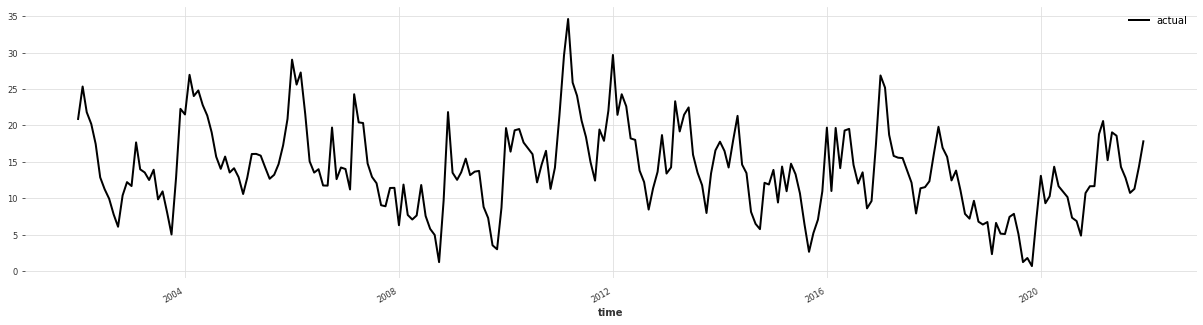

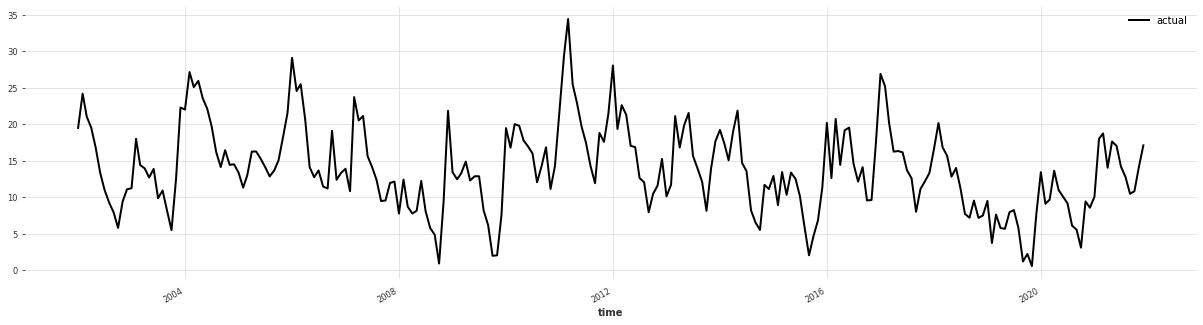

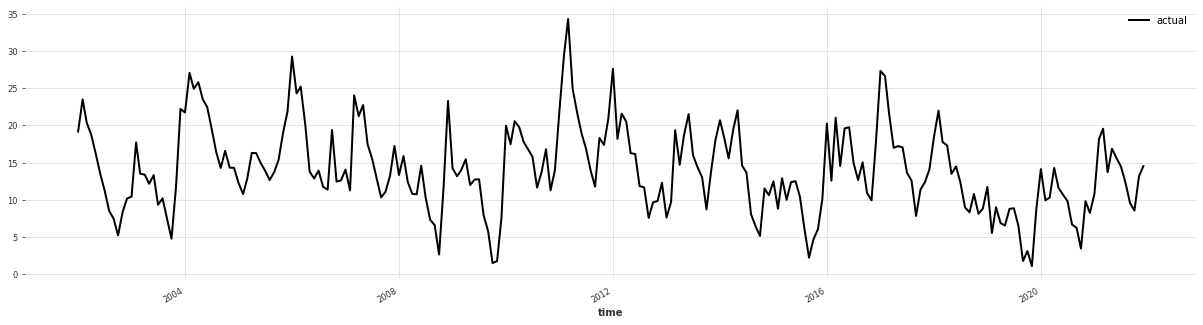

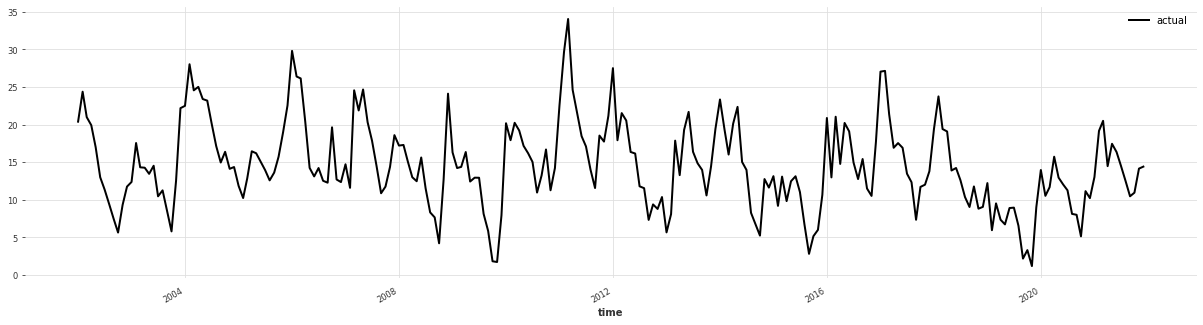

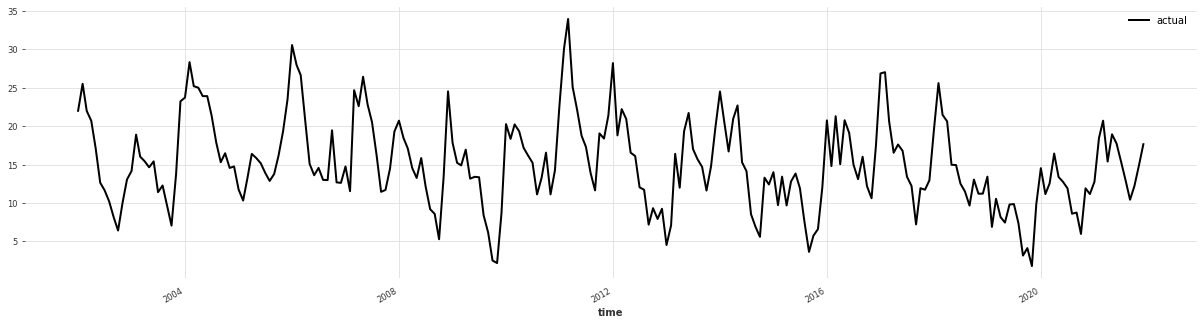

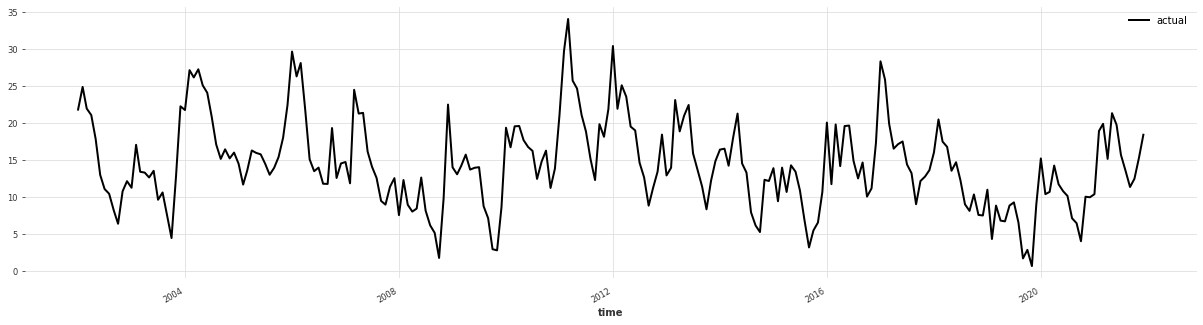

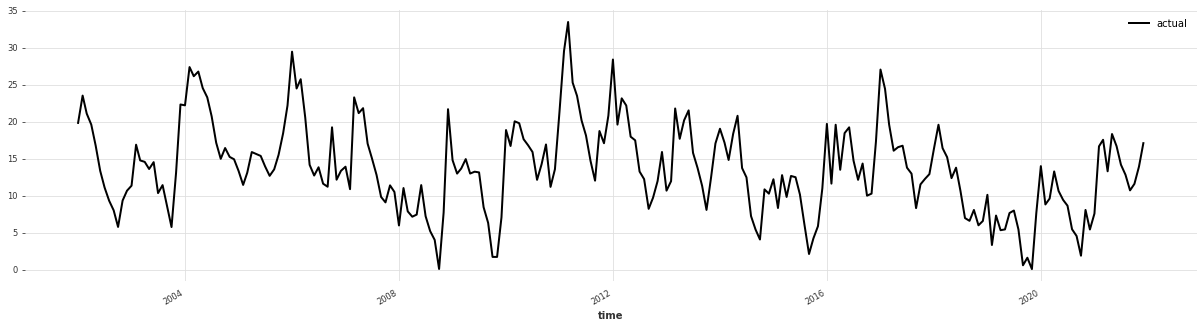

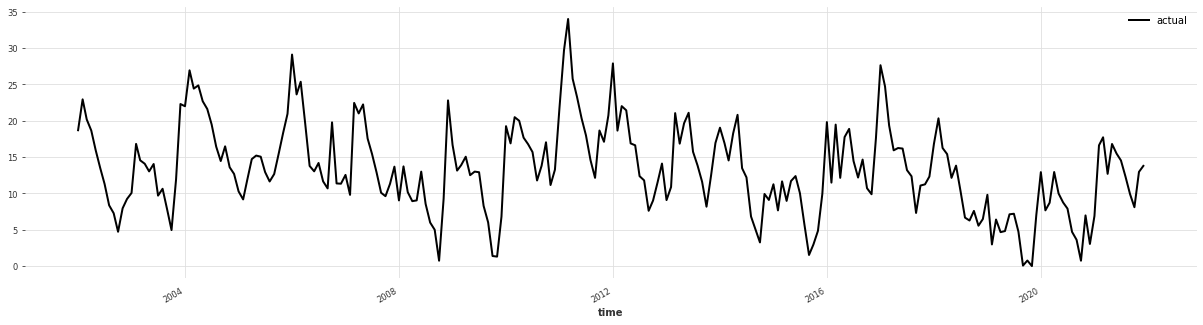

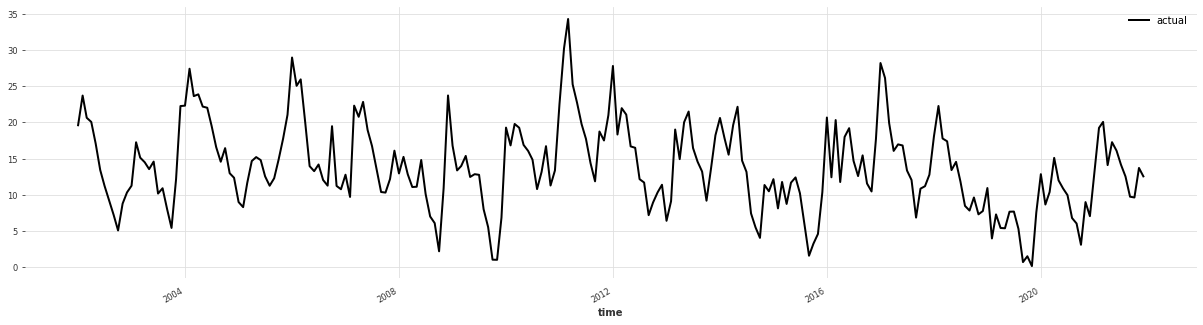

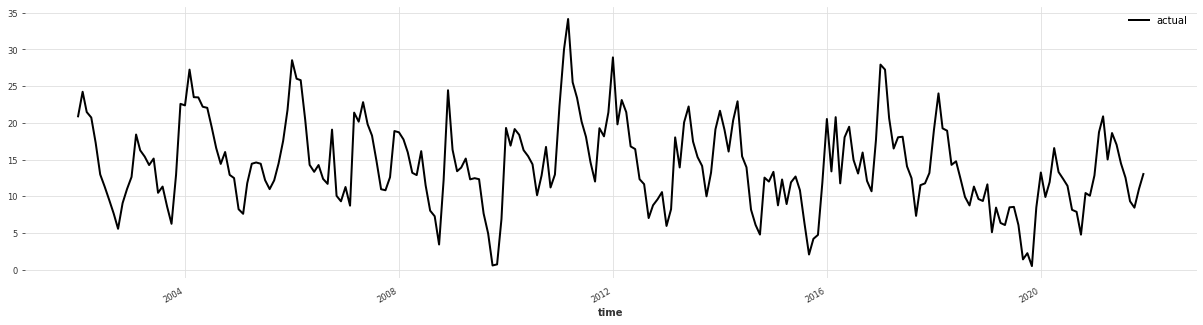

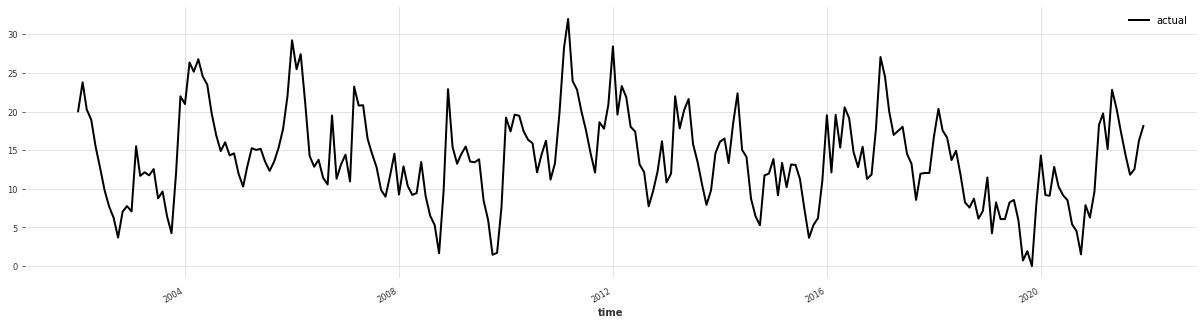

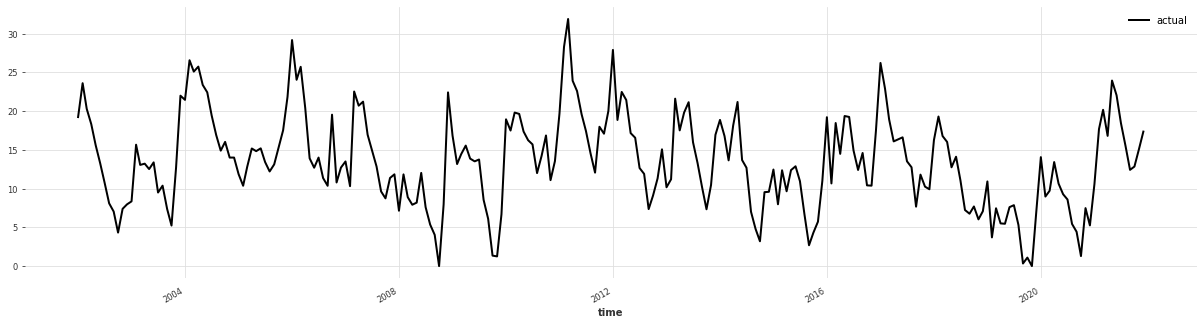

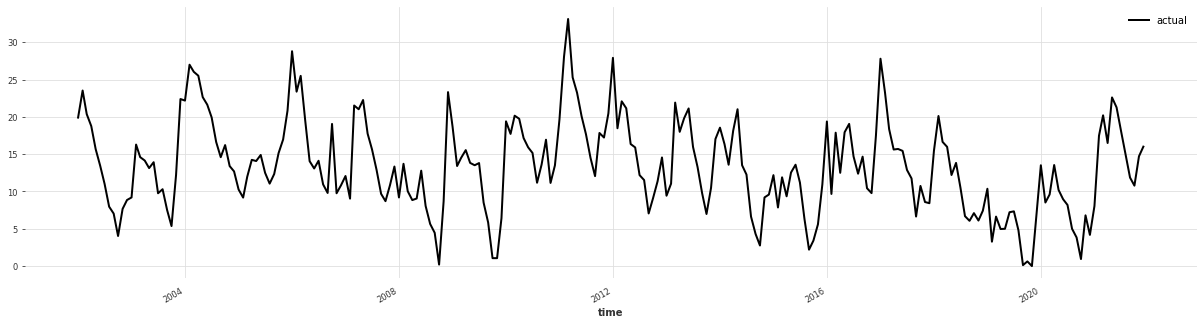

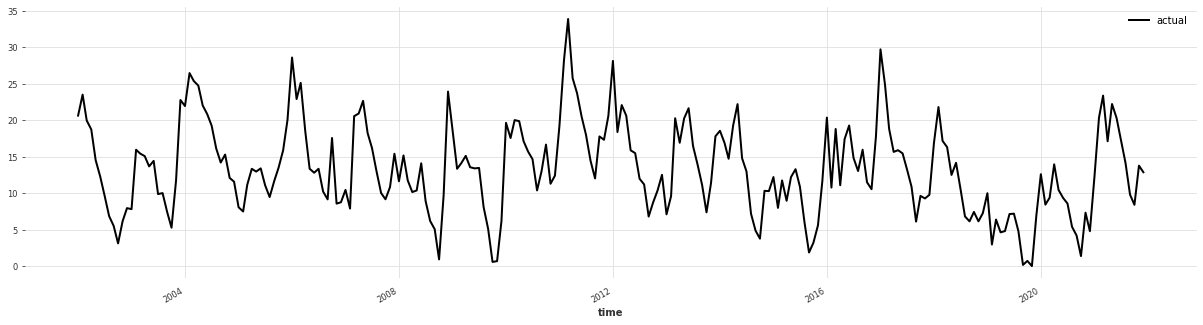

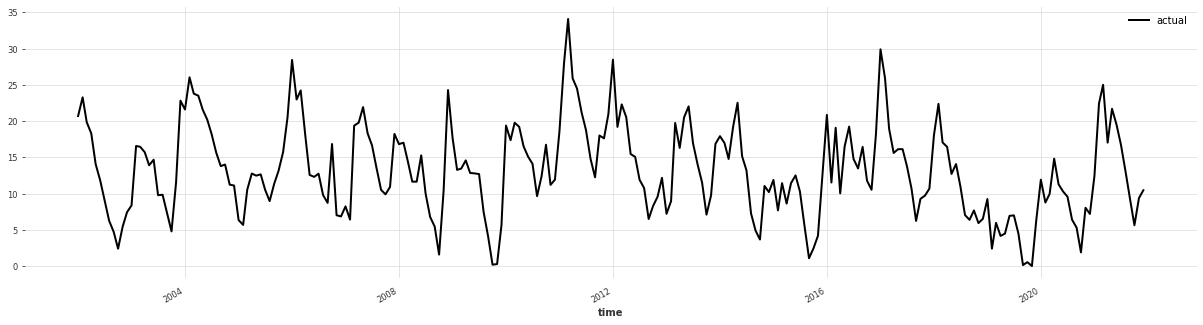

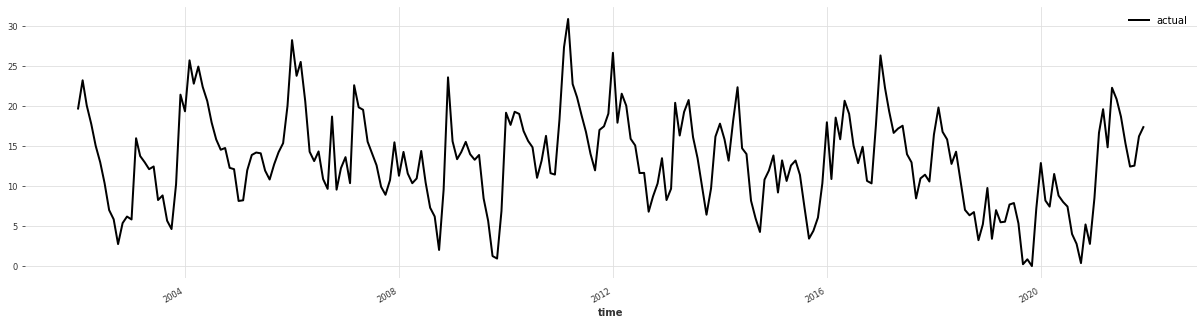

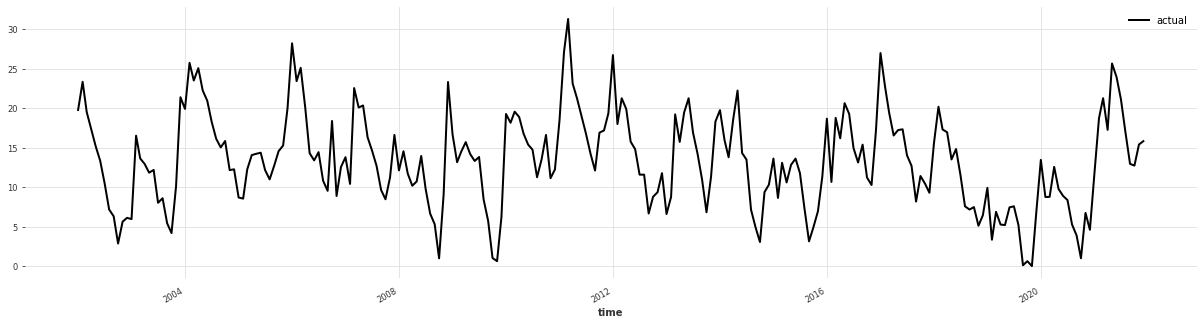

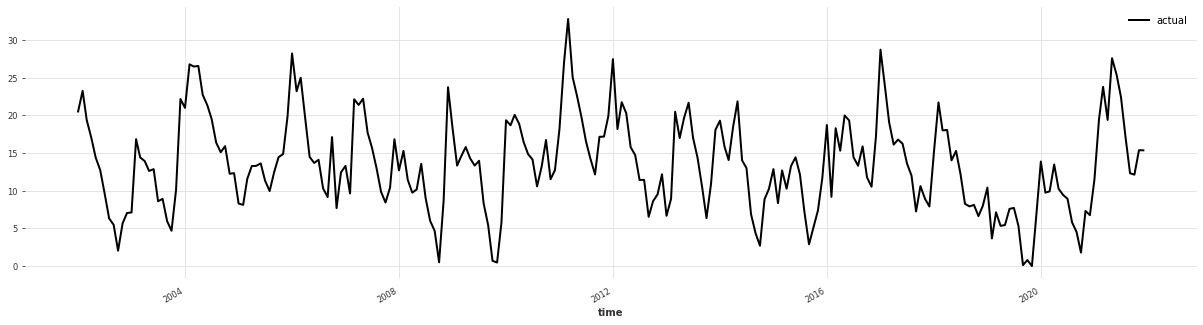

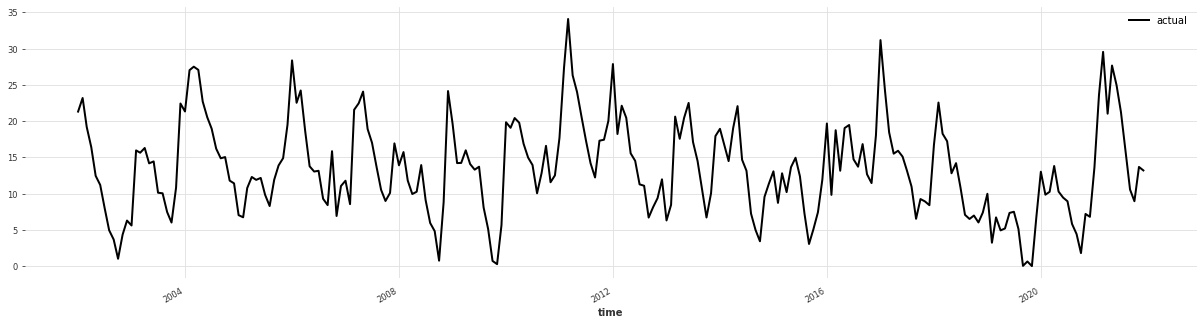

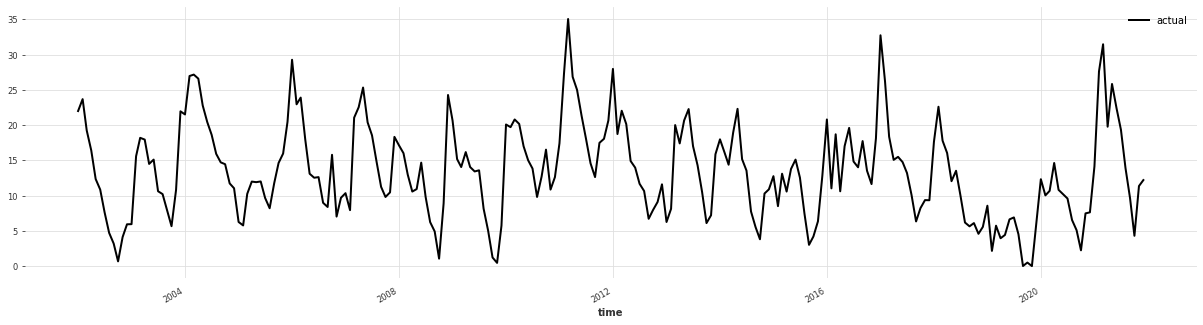

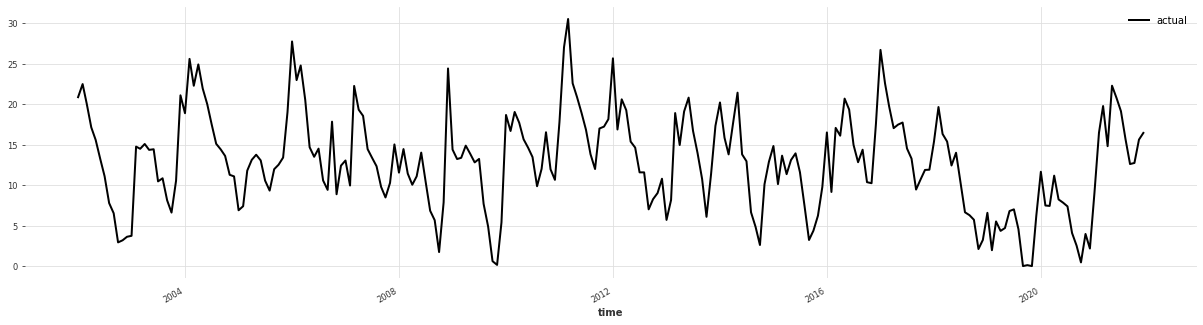

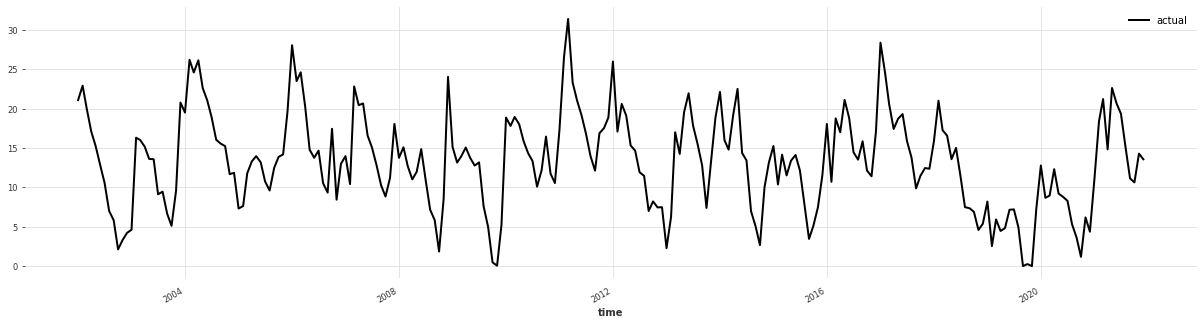

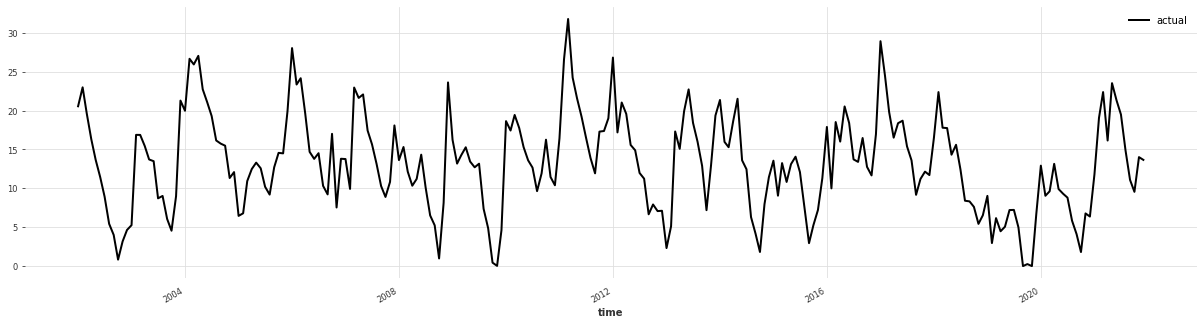

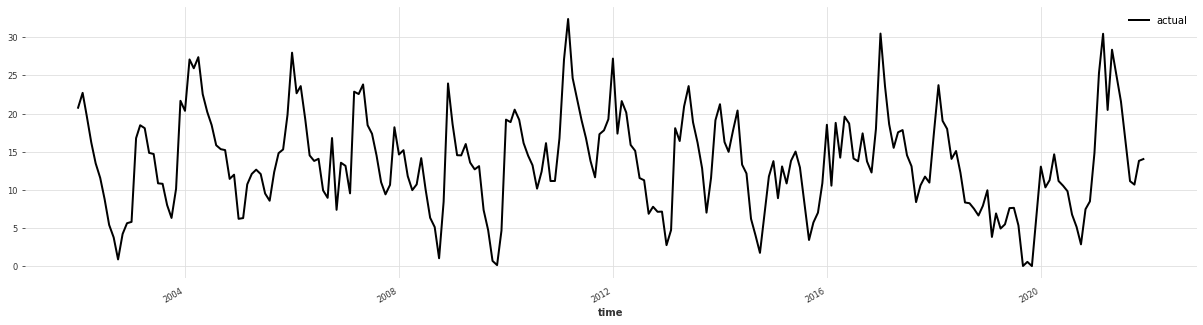

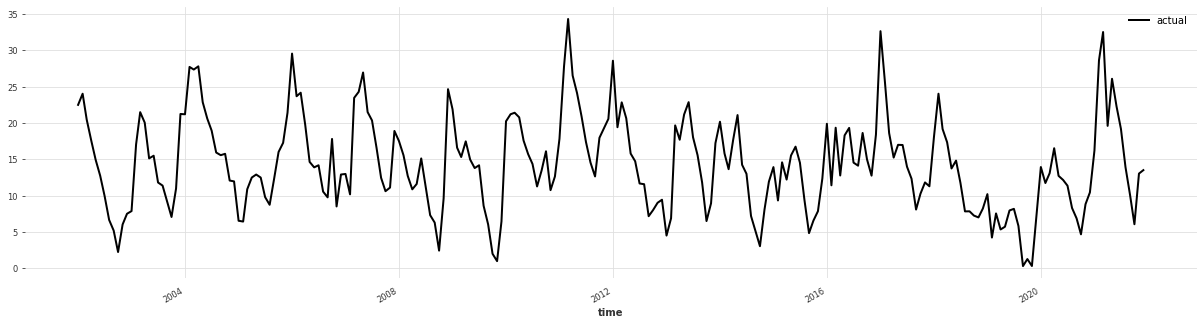

In [50]:
for i in range(0, len(val_list)):
    print(i)
    pred = model.predict(n=len(val_list[i]), series=train_list[i], num_samples=100) #past_covariates=covariates
    #pred_r = scaler.inverse_transform(pred)
    
    fig,ax = plt.subplots(figsize=(21,5))
    tss[i]['GOSIF_GPP_gC_m2_month'].plot(ax=ax, label='actual')
    
    # val = scaler.inverse_transform(val_list[i])
    err = mae(pred_r['GOSIF_GPP_gC_m2_month'], val_list[i]['GOSIF_GPP_gC_m2_month'])

    pred_r['GOSIF_GPP_gC_m2_month'].plot(ax=ax, lw=3,
                                        label='{}, MAE={:.2f}'.format('Forecast', err),
                                         low_quantile=.05, high_quantile=0.95)
    # plt.ylabel(var_names[0]+', gC/m2/week')
    # plt.axhline(0, color='grey')
    plt.legend()

### Iterative backtest

In [ ]:
backtests = model.historical_forecasts(series_gpp_scaled,
                                       # past_covariates=covariates,
                                       num_samples=100,
                                       start=.5,
                                       retrain=False,
                                       forecast_horizon=12,
                                       stride=1,
                                       verbose=True
                                      )


In [ ]:
backtests = scaler.inverse_transform(backtests)

fig,ax = plt.subplots(figsize=(15,6))
series_gpp['GPP_SOLO'].plot(ax=ax, lw=2, label='Observations')

# err = mae(backtests, series_gpp)

backtests['GPP_SOLO'].plot(ax=ax, lw=2, label='{}, MAE={:.2f}'.format('Forecast', err), low_quantile=.05, high_quantile=0.95)
plt.ylabel(var_names[0]+', gC/m2/month')
plt.xlabel('')
# plt.title('Backtests with 3-months forecast horizon')
plt.axvline(pd.Timestamp(series_gpp[idx].data_array().time.values[0]), color='red', linestyle='--')
plt.legend()

### Forecast

In [ ]:
#refit the model on all the data
model.fit(series_gpp_scaled) # past_covariates=covariates

#forecast the future
pred = model.predict(n=12, series=series_gpp_scaled,  num_samples=100) #past_covariates=covariates,

In [ ]:
pred_r = scaler.inverse_transform(pred)

fig,ax = plt.subplots(figsize=(12,5))
series_gpp['GPP_SOLO'].plot(ax=ax, label='actual')
pred_r['GPP_SOLO'].plot(ax=ax, label='forecast', lw=3)
plt.legend()